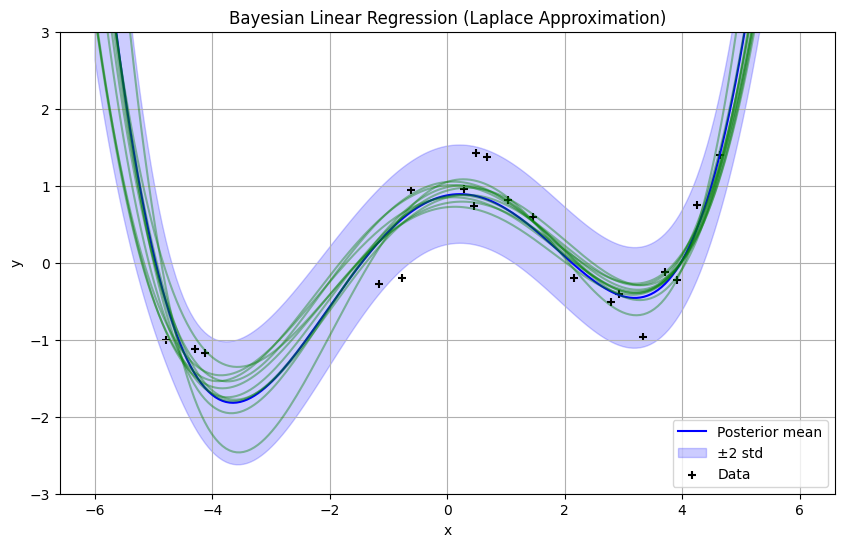

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv

# ------------------------------
# Generate synthetic data
# ------------------------------
np.random.seed(0)

N = 20
x = np.random.uniform(-5, 5, N)
true_func = lambda x: np.sin(x / 5) + np.cos(x)
y_true = true_func(x)
noise_std = 0.3
y = y_true + np.random.normal(0, noise_std, N)

# Design matrix (polynomial basis)
K = 5  # Polynomial degree
Phi = np.vander(x, N=K, increasing=True)

# ------------------------------
# Negative log-posterior
# ------------------------------
alpha = 1.0  # Prior precision (controls weight decay)
sigma2 = noise_std**2  # Observation noise variance

def neg_log_posterior(w, Phi, y, alpha, sigma2):
    y_pred = Phi @ w
    log_likelihood = -0.5 / sigma2 * np.sum((y - y_pred)**2)
    log_prior = -0.5 * alpha * np.sum(w**2)
    return - (log_likelihood + log_prior)

# Gradient of the negative log-posterior
def grad_neg_log_posterior(w, Phi, y, alpha, sigma2):
    return (1 / sigma2) * Phi.T @ (Phi @ w - y) + alpha * w

# ------------------------------
# Laplace approximation (MAP + Hessian)
# ------------------------------
w0 = np.zeros(K)

res = minimize(
    neg_log_posterior,
    w0,
    args=(Phi, y, alpha, sigma2),
    jac=grad_neg_log_posterior,
    method='BFGS'
)

w_map = res.x

# Hessian of the negative log-posterior at MAP
H = (1 / sigma2) * Phi.T @ Phi + alpha * np.eye(K)
S_N = inv(H)  # Posterior covariance (approximate via Laplace)

# ------------------------------
# Prediction
# ------------------------------
xs = np.linspace(-6, 6, 200)
Phi_test = np.vander(xs, N=K, increasing=True)

mean_pred = Phi_test @ w_map

# Predictive variance at each test point
var_pred = np.array([
    phi @ S_N @ phi + sigma2 for phi in Phi_test
])

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(10, 6))
plt.plot(xs, mean_pred, label="Posterior mean", color='blue')
plt.fill_between(xs,
                 mean_pred - 2 * np.sqrt(var_pred),
                 mean_pred + 2 * np.sqrt(var_pred),
                 color='blue', alpha=0.2, label='±2 std')

# Sample functions from posterior
for _ in range(10):
    w_sample = np.random.multivariate_normal(w_map, S_N)
    sample_pred = Phi_test @ w_sample
    plt.plot(xs, sample_pred, color='green', alpha=0.4)

plt.scatter(x, y, c='black', marker='+', label="Data")
plt.title("Bayesian Linear Regression (Laplace Approximation)")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-3, 3)
plt.legend()
plt.grid(True)
plt.show()